In [23]:
import numpy as np
import pandas as pd
import pickle
import time

from joblib import dump, load
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.feature_selection import VarianceThreshold, f_regression, mutual_info_regression, SelectFromModel, RFECV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = '{:20,.15f}'.format

In [26]:
from importlib import reload
# module references for reload
import process_class, output, run_models

from process_class import Process
from output import output_metrics
from run_models import run_nn, run_lgb

reload(process_class)
reload(output)
reload(run_models)

# reimport in case changed
from process_class import Process
from output import output_metrics
from run_models import run_nn, run_lgb

In [27]:
def process_data(raw_data):
    data = {}
    imputer_func = KNNImputer(n_neighbors=30, weights='distance')
    process = Process(
        raw_data['X_train'], raw_data['X_test'], raw_data['X_val'], 
        raw_data['y_train'], raw_data['y_test'], raw_data['y_val'], 
        imputer='func', imputer_func=imputer_func
    ).skew_X().skew_y().fill_nan()
    data['X_train'], data['X_test'], data['X_val'], data['y_train'], data['y_test'], data['y_val'] = process.return_processed()
    return data, process

In [28]:
with open('processed/dataset_all_no_process_data.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)
X_raw = pd.concat([raw_data['X_train'], raw_data['X_test'], raw_data['X_val']])
y_raw = pd.concat([raw_data['y_train'], raw_data['y_test'], raw_data['y_val']])

with open('processed/dataset_all_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
with open('processed/dataset_all_process.pickle', 'rb') as handle:
    process = pickle.load(handle)

X = pd.concat([data['X_train'], data['X_test'], data['X_val']])
y = np.concatenate([data['y_train'], data['y_test'], data['y_val']])

In [29]:
def get_mins_from_result(results):
    for mod in ['nn', 'lgb']:
        for metric in ['smape', 'mape', 'mae', 'rmse']:
            s = [(th, results[th][mod][0]["test"][metric]) for th in results]
            print(mod, metric, min(s, key=lambda t: t[1]))
        for metric in ['adj_r2']:
            s = [(th, results[th][mod][0]["test"][metric]) for th in results]
            print(mod, metric, max(s, key=lambda t: t[1]))

In [30]:
###########################################
# Move raw all dataset through variance threshold
# and output metrics to find the best result
###########################################

In [31]:
dd = {}
for key in raw_data.keys():
    dd[key] = raw_data[key][:50].copy()

In [32]:
dd_proc, dd_process = process_data(dd)

In [33]:
res_back = [dd_proc['y_train'].copy(), dd_proc['y_test'].copy(), dd_proc['y_val'].copy()]
for apply_function in reversed(dd_process.y_process):
    res_back = [apply_function(arr) for arr in res_back]
res_back = [np.rint(arr) for arr in res_back]

Epoch 00065: early stopping
-----------------------------------------------
output NN
with val False
train
smape: 47.745
mape: 132.932
mae: 19,847,136.000
rmse: 37,384,793.000
adj_r2: 1.046
test
smape: 89.370
mape: 52,822.228
mae: 45,363,091.000
rmse: 91,439,435.000
adj_r2: 1.280


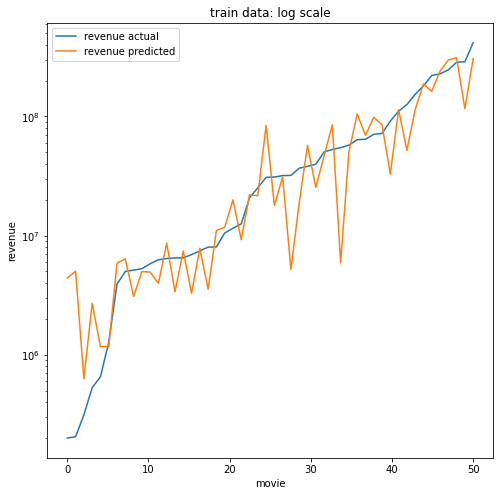

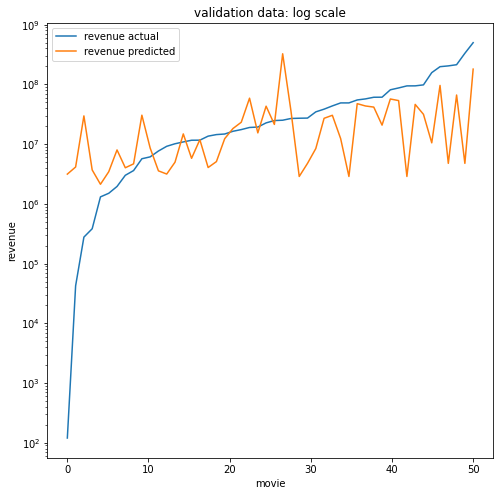

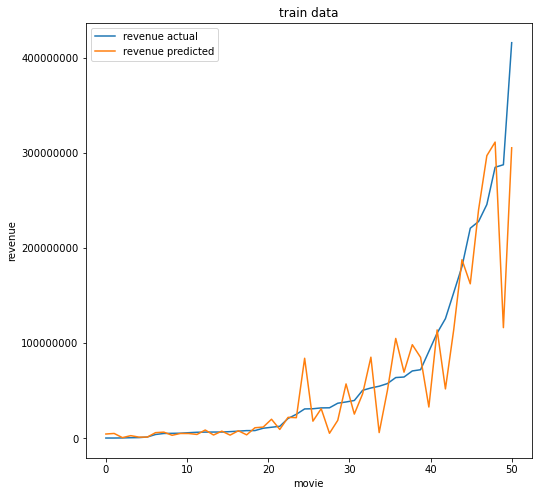

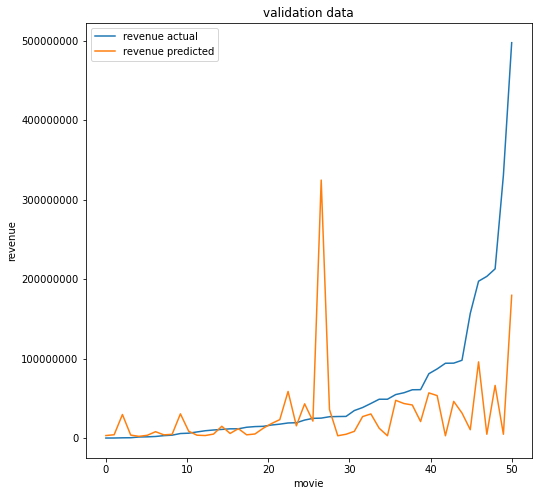

In [39]:
r = run_nn(dd_proc, dd_process, with_val=False)

In [40]:
print(list(dd['y_test']))
list(r[0]['result'][2])

[16367326, 497409852, 3000000, 212874442, 14723313, 7644937, 17460020, 14400000, 10113733, 56996304, 60722734, 120, 86947965, 10848783, 1305195, 26800152, 18948425, 1500000, 97838349, 3600000, 94073028, 48818723, 197309027, 42330, 156835339, 203388186, 25052000, 48814909, 94216343, 11582891, 6102076, 22611954, 27200316, 34573780, 24748670, 13565059, 54700105, 276891, 11614954, 60864870, 1950000, 43498108, 382174, 27053815, 19255873, 330579719, 5675599, 9171289, 38376497, 80916492]


[16367326.0,
 497409852.0,
 3000000.0,
 212874442.0,
 14723313.0,
 7644937.0,
 17460020.0,
 14400000.0,
 10113733.0,
 56996304.0,
 60722734.0,
 120.0,
 86947965.0,
 10848783.0,
 1305195.0,
 26800152.0,
 18948425.0,
 1500000.0,
 97838349.0,
 3600000.0,
 94073028.0,
 48818723.0,
 197309027.0,
 42330.0,
 156835339.0,
 203388186.0,
 25052000.0,
 48814909.0,
 94216343.0,
 11582891.0,
 6102076.0,
 22611954.0,
 27200316.0,
 34573780.0,
 24748670.0,
 13565059.0,
 54700105.0,
 276891.0,
 11614954.0,
 60864870.0,
 1950000.0,
 43498108.0,
 382174.0,
 27053815.0,
 19255873.0,
 330579719.0,
 5675599.0,
 9171289.0,
 38376497.0,
 80916492.0]

In [ ]:
results = {}
for threshold in [0.01, 0.02, 0.03, 0.05, 0.75, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]:
    print('#########################################')
    print(threshold)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X_raw)
    features = selector.get_support(indices=True)
    print(f'{len(features)}\tfeatures')
    d = raw_data.copy()
    for name in ['X_train', 'X_test', 'X_val']:
        d[name] = d[name][d[name].columns[features]]
    data, process = process_data(d)
    results[threshold] = {}
    results[threshold]['features'] = features
    results[threshold]['nn'] = run_nn(data, process)
    results[threshold]['lgb'] = run_lgb(data, process)

In [ ]:
get_mins_from_result(results)

In [ ]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_raw)
features_VT = [X_raw.columns[i] for i in selector.get_support(indices=True)]
print(len(features_VT))
print(features_VT)

In [ ]:
####################################
# f_regression
####################################
results = {}

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

num_features_list = []
threshold = 0.000001
while threshold < 0.2:
    features = [col for i, col in enumerate(data['X_train'].columns) if f_test[i] >= threshold]
    num_features = len(features)
    if num_features not in num_features_list:
        num_features_list.append(num_features)
        print('#########################################')
        print(f'{threshold}\tthreshold')
        print(f'{num_features}\tnum features')

        d = raw_data.copy()
        for name in ['X_train', 'X_test', 'X_val']:
            d[name] = d[name][features]
        data_run, process_run = process_data(d)
        results[threshold] = {}
        results[threshold]['features'] = features
        results[threshold]['nn'] = run_nn(data_run, process_run)
        results[threshold]['lgb'] = run_lgb(data_run, process_run)
    if threshold < 0.01:
        threshold += 0.001
    else:
        threshold += 0.01

In [ ]:
get_mins_from_result(results)

In [ ]:
features_FTEST = [col for i, col in enumerate(data['X_train'].columns) if f_test[i] >= 0.003]
print(len(features_FTEST))
print(features_FTEST)

In [ ]:
####################################
# mutual info regression
####################################
results_minfo = {}

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

num_features_list = []
threshold = 0.0
while threshold < 0.4:
    features = [col for i, col in enumerate(data['X_train'].columns) if mi[i] >= threshold]
    num_features = len(features)
    if num_features not in num_features_list:
        num_features_list.append(num_features)
        print('#########################################')
        print(f'{threshold}\tthreshold')
        print(f'{num_features}\tnum features')

        d = raw_data.copy()
        for name in ['X_train', 'X_test', 'X_val']:
            d[name] = d[name][features]
        data_run, process_run = process_data(d)
        results_minfo[threshold] = {}
        results_minfo[threshold]['features'] = features
        results_minfo[threshold]['nn'] = run_nn(data_run, process_run)
        results_minfo[threshold]['lgb'] = run_lgb(data_run, process_run)
    if threshold < 0.01:
        threshold += 0.001
    else:
        threshold += 0.01

In [ ]:
get_mins_from_result(results_minfo)

In [ ]:
features_MIR = [col for i, col in enumerate(data['X_train'].columns) if mi[i] >= 0.006]
print(len(features_MIR))
print(features_MIR)

In [ ]:
####################################
# Select from model
####################################

def get_RFR_model():
    return RandomForestRegressor(
        n_estimators=40,
        max_depth=15,
        min_samples_split=0.001,
        min_samples_leaf=0.0005,
        bootstrap=True,
        max_samples=0.95,
        criterion='mae', 
        random_state=0, 
        n_jobs=-1,
    )

results_select = {}
num_features_list = []
threshold = 0.0
while threshold < 1.0:
    start_time = time.time()
    model = get_RFR_model()
    selector = SelectFromModel(estimator=model, prefit=False, threshold=f'{threshold}*mean')
    selector.fit(X,y)
    features = [X.columns[i] for i in selector.get_support(indices=True)]
    num_features = len(features)
    if num_features not in num_features_list:
        num_features_list.append(num_features)
        print('#########################################')
        print(f'{threshold}\tthreshold')
        print(f'{num_features}\tnum features')
        d = raw_data.copy()
        for name in ['X_train', 'X_test', 'X_val']:
            d[name] = d[name][features]
        data_run, process_run = process_data(d)
        results_select[threshold] = {}
        results_select[threshold]['selector'] = selector
        results_select[threshold]['features'] = features
        results_select[threshold]['nn'] = run_nn(data_run, process_run)
        results_select[threshold]['lgb'] = run_lgb(data_run, process_run)
    if threshold < 0.1:
        threshold += 0.01
    else:
        threshold += 0.1
    print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
get_mins_from_result(results_select)

In [14]:
####################################################################################
# RFECV feature selection with LR
####################################################################################

selector = RFECV(LinearRegression(), n_jobs=-1)
selector = selector.fit(X, y)

135
['budget', 'runtime', 'spoken_languages', 'weekend', 'genre__western', 'genre__romance', 'genre__animation', 'genre__comedy', 'genre__history', 'genre__fantasy', 'genre__horror', 'country__ca', 'country__cn', 'country__in', 'country__fr', 'country__it', 'country__gb', 'competition', 'rating__g', 'rating__pg', 'rating__pg-13', 'rating__r', 'tag__violence', 'tag__romantic', 'tag__cult', 'tag__revenge', 'tag__psychedelic', 'tag__comedy', 'tag__suspenseful', 'tag__humor', 'tag__entertaining', 'tag__action', 'tag__tragedy', 'tag__fantasy', 'tag__paranormal', 'tag__boring', 'tag__mystery', 'tag__horror', 'tag__melodrama', 'tag__cruelty', 'tag__dramatic', 'tag__sci_fi', 'tag__historical', 'tag__absurd', 'tag__prank', 'tag__sentimental', 'tag__realism', 'tag__cute', 'tag__inspiring', 'tag__other', 'cast_6_gender', 'homepage_exists', 'production_company_1_avg_profit', 'production_company_1_avg_revenue', 'production_company_2_avg_revenue', 'production_company_3_avg_profit', 'production_compa

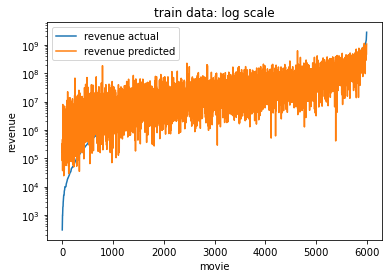

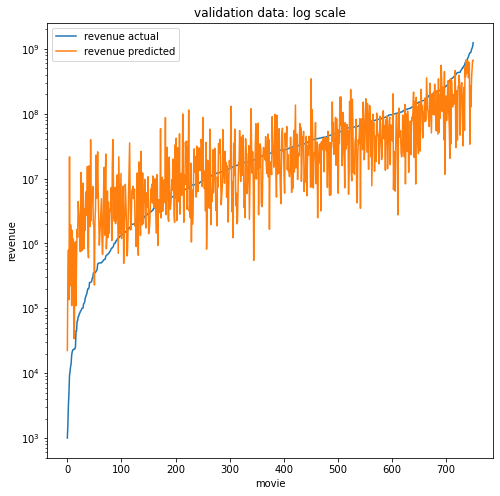

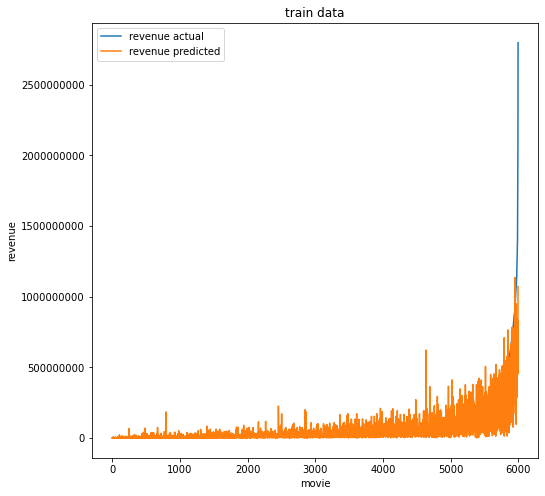

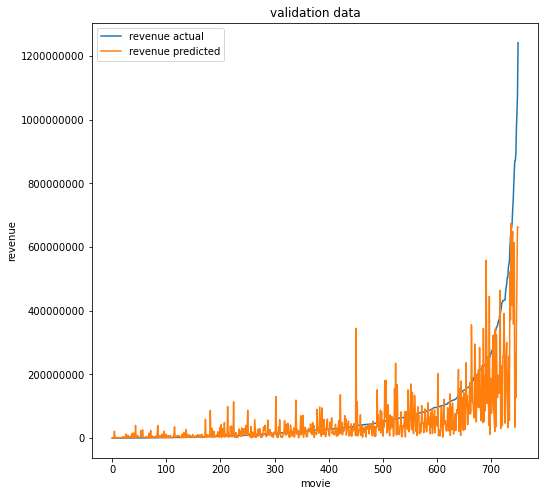

-----------------------------------------------
output LGBMRegressor
train
smape: 64.754
mape: 385.547
mae: 33,115,728.000
rmse: 86,757,916.000
adj_r2: 0.719
test
smape: 79.235
mape: 554.442
mae: 42,545,626.000
rmse: 95,901,998.000
adj_r2: 0.483


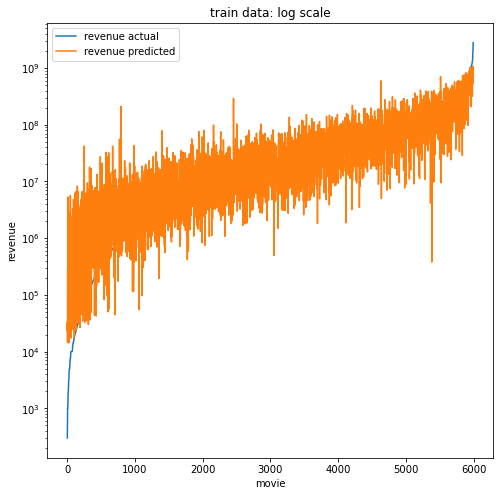

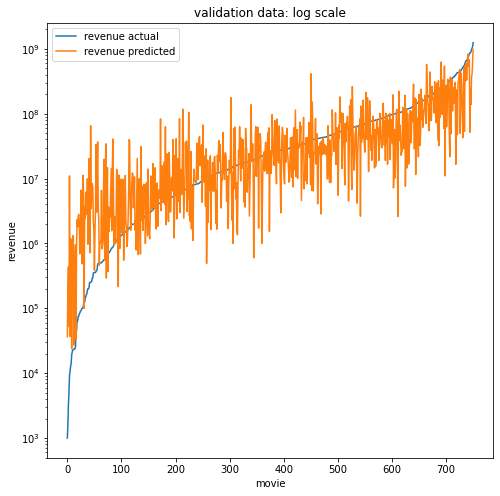

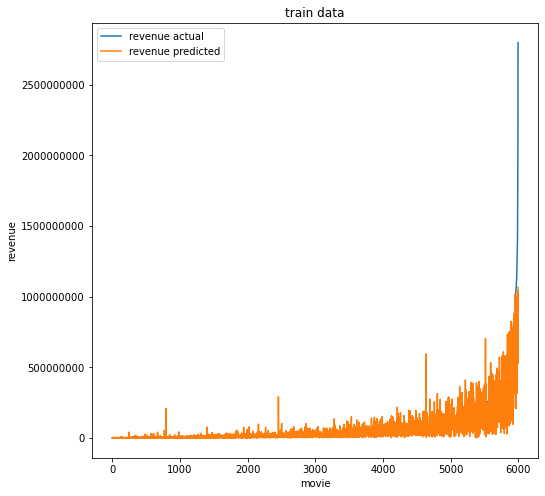

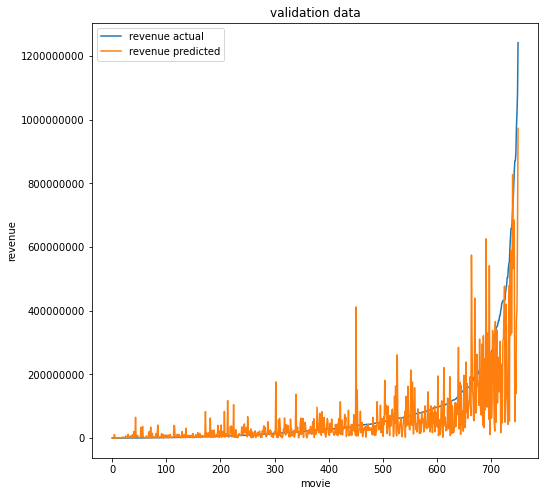

({'train': {'smape': 64.75417459123547,
   'mape': 385.5468725111435,
   'mae': 33115728.0,
   'rmse': 86757916.0,
   'adj_r2': 0.7193557454553433},
  'test': {'smape': 79.23468401258269,
   'mape': 554.4422165732419,
   'mae': 42545626.0,
   'rmse': 95901998.0,
   'adj_r2': 0.4830395439563545}},
 LGBMRegressor(bagging_fraction=0.98, bagging_freq=15, bagging_seed=9,
               colsample_bytree=0.87, feature_fraction=0.77, learning_rate=0.001,
               max_bin=192, max_depth=0, min_child_samples=160,
               min_data_in_leaf=1, min_sum_hessian_in_leaf=50, n_estimators=7500,
               num_leaves=34, objective='huber', reg_alpha=0.18, reg_lambda=30,
               subsample=0.39, tree_learner='data'))

In [15]:
features_RFECV_LR = [X.columns[i] for i in selector.get_support(indices=True)]
print(len(features_RFECV_LR))
print(features_RFECV_LR)

d = raw_data.copy()
for name in ['X_train', 'X_test', 'X_val']:
    d[name] = d[name][features_RFECV_LR]
data_run, process_run = process_data(d)
run_nn(data_run, process_run)
run_lgb(data_run, process_run)

In [ ]:
####################################################################################
# RFECV feature selection with AdaBoostRegressor
####################################################################################

model = get_RFR_model()
abr = AdaBoostRegressor(
    base_estimator=model,
    loss='exponential',
    random_state=0
)

selector_adaboost = RFECV(abr, n_jobs=-1)
selector_adaboost = selector.fit(X, y)

In [ ]:
features_RFECV_adaboost = [X.columns[i] for i in selector_adaboost.get_support(indices=True)]
print(len(features_RFECV_adaboost))
print(features_RFECV_adaboost)

d = raw_data.copy()
for name in ['X_train', 'X_test', 'X_val']:
    d[name] = d[name][features_RFECV_adaboost]
data_run, process_run = process_data(d)
run_nn(data_run, process_run)
run_lgb(data_run, process_run)

In [ ]:
#########################################
# RFECV feature selection with tuned RF #
#########################################

In [ ]:
model = RandomForestRegressor(
    n_estimators=40,
    max_depth=15,
    min_samples_split=0.001,
    min_samples_leaf=0.0005,
    bootstrap=True,
    max_samples=0.95,
    criterion='mae', 
    random_state=0, 
    n_jobs=-1,
    verbose=1,
)
selector = RFECV(model, verbose=10, n_jobs=-1)

In [ ]:
selector = selector.fit(data['X_train'], data['y_train'])

In [ ]:
joblib.dump(selector, 'rfecv_selector_joblib_2.sav')
pickle.dump(selector, open('rfecv_selector_pickle_2.sav', 'wb'))

In [ ]:
# RFECV RFR
with open('rfecv_selector_pickle_2.sav', 'rb') as handle:
    rfecv_rfr = pickle.load(handle)

features_RFECV_RFR = [X.columns[i] for i in rfecv_rfr.get_support(indices=True)]
print(len(features_RFECV_RFR))
print(features_RFECV_RFR)

# d = raw_data.copy()
# for name in ['X_train', 'X_test', 'X_val']:
#     d[name] = d[name][features_RFECV_LR]
# data_run, process_run = process_data(d)
# run_nn(data_run, process_run)
# run_lgb(data_run, process_run)

In [ ]:
# RFECV ETR
rfecv_etr = load('rfecv_selector_joblib_etr.sav')

features_RFECV_ETR = [X.columns[i] for i in rfecv_etr.get_support(indices=True)]
print(len(features_RFECV_ETR))
print(features_RFECV_ETR)

d = raw_data.copy()
for name in ['X_train', 'X_test', 'X_val']:
    d[name] = d[name][features_RFECV_ETR]
data_run, process_run = process_data(d)
run_nn(data_run, process_run)
run_lgb(data_run, process_run)